# Classification for 8 classes.
`fake euphoria` vs `fake goodgirl` vs `fake ysly` vs `fake theone`

`og_euphoria` vs `og_goodgirl` vs  `og ysly` vs `og_theone`

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, classification_report

# Read and prepare dataset

In [2]:
dataset = np.load('../perfumes-dataset.npz', allow_pickle=True)['data'].tolist()
dataset = [d for d in dataset if 'sauvage' not in d['name']] # exclude 'sauvage' as we dont have og to compare

In [3]:
signals = [d['data'] for d in dataset]

In [4]:
signals_array = np.array(signals)

print('Signals shape:', signals_array.shape)

Signals shape: (16, 8, 4, 10, 101)


## Extract resistances channel 

In [5]:
resistances = signals_array[:, :, 0, :]

In [6]:
# assert only resistance is here

resistances[resistances<7000] # all g

array([], dtype=float64)

## Normalize data along sensor dimension 

In [7]:
perftype_splitted = []
for perf in resistances:
    sensor_splitted = []
    for sensor in perf:
        cycle_normalized = []
        for cycle in sensor:
            # print(cycle.shape)
            mean_val = cycle.mean()
            std_val = cycle.std()
            normalized_val = (cycle - mean_val)/std_val

            cycle_normalized.append(normalized_val)
        
        sensor_splitted.append(cycle_normalized)
    perftype_splitted.append(sensor_splitted)


resistances_normalized = np.array(perftype_splitted)

In [8]:
# concatenate 
resistances = []
for perf in resistances_normalized:
    reshaped_resistancy = perf.reshape((80, 101))
    resistances.append(reshaped_resistancy)

resistances = np.array(resistances)

## Convert to `np.ndarray`

In [9]:
labels = [d['name'] for d in dataset]
X = []
y = []
for res, lab in zip(resistances, labels):
    X.append(res)
    y.append([lab]*80)

X = np.array(X).reshape((16*80, 101))
y = np.array(y).reshape((16*80))


In [10]:
X.shape, y.shape

((1280, 101), (1280,))

## Assign `*_sam/bg` to same class

In [11]:
y_ = [_.split('_')[0:2] for _ in y]
y_ = [x[0] + '_' + x[1] for x in y_]
y = np.array(y_)

In [12]:
np.unique(y)

array(['fake_euphoria', 'fake_goodgirl', 'fake_theone', 'fake_ysly',
       'og_euphoria', 'og_goodgirl', 'og_theone', 'og_ysly'], dtype='<U13')

# One-Hot Encoding

In [13]:
oh = OneHotEncoder(sparse_output=True)
oh = oh.fit(y.reshape(-1, 1))


y = oh.transform(y.reshape(-1, 1))
y = y.toarray()

In [14]:
y.shape

(1280, 8)

# Prepare `torch` loaders and model

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), self.y[idx]

In [16]:
X.shape

(1280, 101)

In [17]:
np.random.seed(2023)
permutation_idx = np.random.randint(low = 0, high = len(X), size = len(X)) 

X = X[permutation_idx]
y = y[permutation_idx]

In [18]:
X = torch.tensor(X).to(torch.float32)
y = torch.tensor(y, dtype = torch.float16)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2024)

In [19]:
print('Train dataset shape;', X_train.shape)
print('Val dataset shape;', X_val.shape)
print('Test dataset shape;', X_test.shape)


Train dataset shape; torch.Size([896, 101])
Val dataset shape; torch.Size([192, 101])
Test dataset shape; torch.Size([192, 101])


## Noise addition to increase number of training samples

In [20]:
noised_signals = []
noised_labels = []
for x, y in zip(X_train, y_train):
    p = np.random.randint(0, 100, 1)
    if p % 2 == 0:
        noise = np.random.normal(loc = 0, scale = x.std()/6, size = len(x))
        x_noised = x + noise
        noised_signals.append(x_noised)
        noised_labels.append(y)

noised_signals = np.array(noised_signals)
noised_labels = np.array(noised_labels)

In [21]:
print('Noised samples:', noised_signals.shape[0])

Noised samples: 458


In [22]:
X_train = torch.row_stack((X_train, torch.tensor(noised_signals))).to(torch.float32)
y_train = torch.row_stack((y_train, torch.tensor(noised_labels)))


In [23]:
print('New train shape:', X_train.shape)

New train shape: torch.Size([1354, 101])


In [24]:
class PerfumeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flat = nn.Flatten()
        self.d1 = nn.Linear(in_features=101, out_features=256)
        self.relu1 = nn.ReLU()

        self.d2 = nn.Linear(in_features=256, out_features=64)
        self.relu2 = nn.ReLU()

        self.out = nn.Linear(in_features=64, out_features=8)
        self.smax = nn.Softmax()
        # self.out = nn.Linear(in_features=128, out_features=8)
    def forward(self, x):
        # outputs = self.flat(x)
        outputs = x
        
        outputs = self.relu1(self.d1(outputs))
        
        outputs = self.relu2(self.d2(outputs))
        
        outputs = self.out(outputs)

        # outputs = self.smax(outputs)
        return outputs


In [25]:
BATCH_SIZE = 64


train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TimeSeriesDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [26]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    losses = []
    accs = []
    for i, batch in enumerate(data_loader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = loss_fn(outputs, y)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        y_truth = torch.where(y != 0)[1]
        y_pred = torch.max(outputs, 1)[1]


        total_correct = (y_truth == y_pred).sum().item()
        total_samples = y.size(0)
        
        accuracy = total_correct / total_samples
        
        losses.append(loss.item())
        accs.append(accuracy)


    return np.mean(losses), np.mean(accuracy)



def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    accs = []
    for i, batch in enumerate(data_loader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = loss_fn(outputs, y)
    
        y_truth = torch.where(y != 0)[1]
        y_pred = torch.max(outputs, 1)[1]

        total_correct = (y_truth == y_pred).sum().item()
        total_samples = y.size(0)
        
        accuracy = total_correct / total_samples
        

        losses.append(loss.item())
        accs.append(accuracy)

    return np.mean(losses), np.mean(accs)




In [27]:
EPOCHS = 1000
LR = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PerfumeClassifier()
model = model.to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()


In [28]:
from collections import defaultdict
import copy


history = defaultdict(list)
best_val_loss = float('inf')  # Initialize with a large value
best_val_acc = None
best_model = None

counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, DEVICE)

    print(f"EPOCH {epoch+1}/{EPOCHS}")
    print(f"Train loss:  {train_loss} \t Train accuracy: {train_acc}")
    print(f"Val loss: {val_loss} \t Val accuracy: {val_acc}")

    if val_loss < best_val_loss:
        print('*'*10)
        print('New best!')
        print('*'*10)
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1

    if counter > 100:
        print('Early stopping called!')
        print('Training finished')
        break

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)


EPOCH 1/1000
Train loss:  2.074176062237133 	 Train accuracy: 0.1
Val loss: 2.0602235794067383 	 Val accuracy: 0.1875
**********
New best!
**********
EPOCH 2/1000
Train loss:  2.0457641048864885 	 Train accuracy: 0.6
Val loss: 2.0365455945332847 	 Val accuracy: 0.20833333333333334
**********
New best!
**********
EPOCH 3/1000
Train loss:  2.02287139675834 	 Train accuracy: 0.2
Val loss: 2.0106948216756186 	 Val accuracy: 0.21354166666666666
**********
New best!
**********
EPOCH 4/1000
Train loss:  1.9990017793395303 	 Train accuracy: 0.1
Val loss: 1.9820984204610188 	 Val accuracy: 0.21875
**********
New best!
**********
EPOCH 5/1000
Train loss:  1.9680127772417935 	 Train accuracy: 0.4
Val loss: 1.9594731728235881 	 Val accuracy: 0.20833333333333334
**********
New best!
**********
EPOCH 6/1000
Train loss:  1.945015788078308 	 Train accuracy: 0.2
Val loss: 1.9325389862060547 	 Val accuracy: 0.2604166666666667
**********
New best!
**********
EPOCH 7/1000
Train loss:  1.9212209148840471 	

In [29]:
print('Best val loss:', best_val_loss)
print('Best val accuracy:', best_val_acc)


Best val loss: 0.8009336193402609
Best val accuracy: 0.7864583333333334


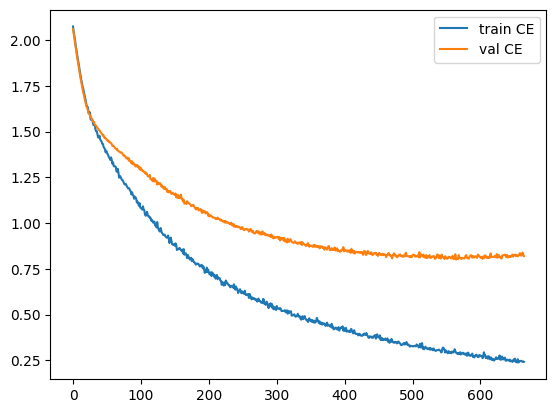

In [30]:

plt.plot(history['train_loss'], label = 'train CE')
plt.plot(history['val_loss'], label = 'val CE')

plt.legend()

# Evaluate on test dataset

In [31]:
with torch.no_grad():
    y_pred = model(X_test.to(DEVICE))
    y_pred_labels = oh.inverse_transform(y_pred.detach().cpu())

y_test_labels = oh.inverse_transform(y_test)

In [32]:
cm = confusion_matrix(y_true= y_test_labels, y_pred = y_pred_labels)

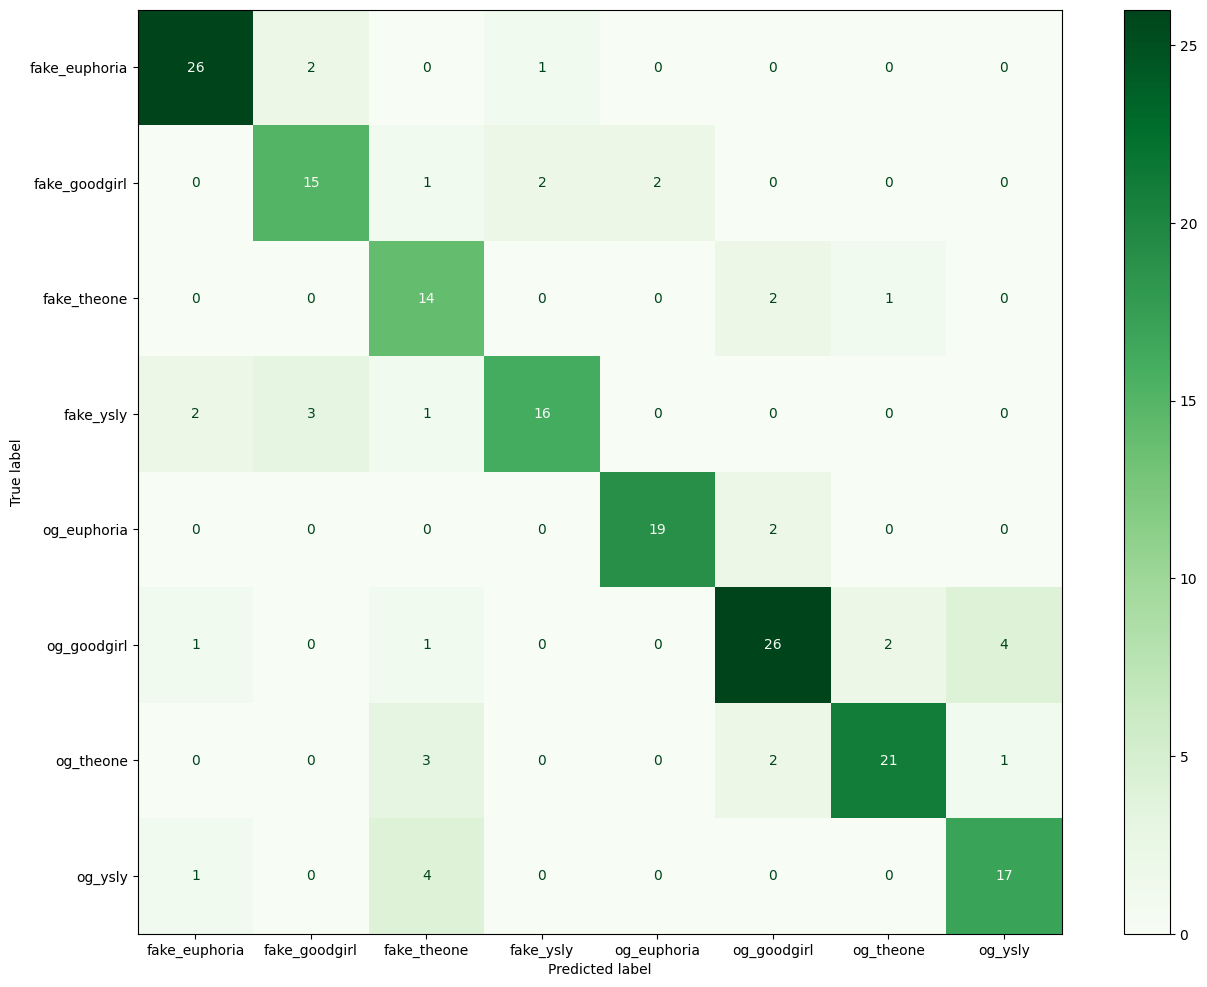

In [33]:
cm_disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test_labels))

fig, ax = plt.subplots(figsize=(16, 12))
cm_disp.plot(ax = ax, cmap = plt.cm.Greens)


In [34]:
print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))

               precision    recall  f1-score   support

fake_euphoria       0.87      0.90      0.88        29
fake_goodgirl       0.75      0.75      0.75        20
  fake_theone       0.58      0.82      0.68        17
    fake_ysly       0.84      0.73      0.78        22
  og_euphoria       0.90      0.90      0.90        21
  og_goodgirl       0.81      0.76      0.79        34
    og_theone       0.88      0.78      0.82        27
      og_ysly       0.77      0.77      0.77        22

     accuracy                           0.80       192
    macro avg       0.80      0.80      0.80       192
 weighted avg       0.81      0.80      0.80       192

